# Logistic Regression 기여도 분석

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

### 모델링을 위한 데이터 전처리

#### 데이터 불러오기

In [ ]:
with open('/content/drive/MyDrive/Colab_Notebooks/campaign_50.pkl', 'rb') as f:
    agg_df = pickle.load(f)

#### 데이터셋 세분화

In [ ]:
# Features Matrix, Label Vector Split
X = np.stack(agg_df['features'].map(lambda x: np.hstack(x)).values)
y = agg_df['conversion'].values

print(X.shape, y.shape)

(95388, 406) (95388,)


In [ ]:
# Train / Test Dataset Split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

# Train / Validation Dataset Split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2)

---

### Logistic Regression 모델링
- tensorflow.keras 를 이용해 모델링 진행

In [ ]:
# Features Matrix의 변수의 개수를 입력노드로 받아 결과로서 한 개의 노드를 출력하는 네트워크 생성
model = keras.Sequential()  
model.add(layers.Dense(1, input_dim=X.shape[1], activation='sigmoid', name='contributions')) 

# optimizer & loss function 지정
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 

In [ ]:
# 과적합 방지 및 best_model 추출을 위한 callback 함수 설정
MODEL_SAVE_FOLDER_PATH = '/content/drive/MyDrive/Colab_Notebooks/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'logistic_regression.h5'
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max',
                                   verbose=0, save_best_only=True)

earlystopper = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=10, verbose=1)

In [ ]:
# 모델 학습
history = model.fit(
    train_x, train_y, 
    batch_size=128, epochs=100, 
    validation_data=(valid_x, valid_y),
    callbacks=[earlystopper, model_checkpoint]                
) 

Epoch 1/100
477/477 [==============================] - 6s 5ms/step - loss: 0.5510 - accuracy: 0.7717 - val_loss: 0.4969 - val_accuracy: 0.8054
Epoch 2/100
477/477 [==============================] - 2s 4ms/step - loss: 0.4642 - accuracy: 0.8080 - val_loss: 0.4577 - val_accuracy: 0.8140
Epoch 3/100
477/477 [==============================] - 2s 4ms/step - loss: 0.4382 - accuracy: 0.8169 - val_loss: 0.4414 - val_accuracy: 0.8247
Epoch 4/100
477/477 [==============================] - 2s 4ms/step - loss: 0.4247 - accuracy: 0.8248 - val_loss: 0.4320 - val_accuracy: 0.8305
Epoch 5/100
477/477 [==============================] - 2s 4ms/step - loss: 0.4163 - accuracy: 0.8295 - val_loss: 0.4263 - val_accuracy: 0.8350
Epoch 6/100
477/477 [==============================] - 2s 4ms/step - loss: 0.4105 - accuracy: 0.8332 - val_loss: 0.4223 - val_accuracy: 0.8372
Epoch 7/100
477/477 [==============================] - 2s 4ms/step - loss: 0.4062 - accuracy: 0.8360 - val_loss: 0.4196 - val_accuracy: 0.8388

In [ ]:
# Best Model에 대한 Validation Accuracy 추출
max_acc_idx = np.argmax(history.history['val_accuracy'])
print(f"Best Accuracy : {np.round(history.history['val_accuracy'][max_acc_idx], 4)}")

Best Accuracy : 0.8564


In [ ]:
# best model 성능 평가
best_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/logistic_regression.h5")

score = best_model.evaluate(test_x, test_y)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

597/597 [==============================] - 2s 3ms/step - loss: 0.3804 - accuracy: 0.8542
Test score: 0.38035282492637634
Test accuracy: 0.8541775941848755


---

### Logistic Regression Attribution Weights 시각화

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# best model의 가중치 벡터 추출
best_weights = best_model.get_layer('contributions').get_weights()[0].flatten()

# 가중치에 대한 데이터프레임 생성
weights_df = pd.DataFrame(best_weights.reshape(-1, 1)).rename({0: 'weights'}, axis=1)
weights_df.head(3)

,weights
0,0.027830
1,-0.246636
2,-0.839124


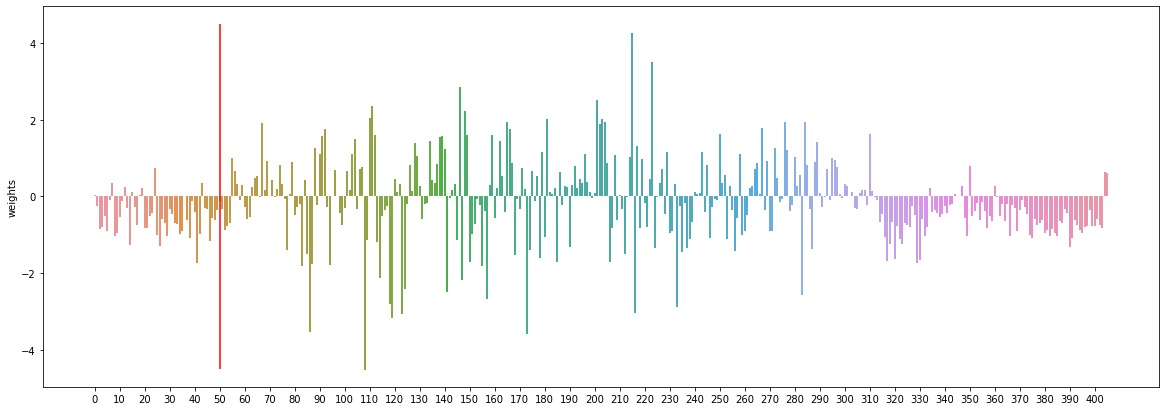

In [5]:
plt.figure(figsize=(20, 7))

sns.barplot(data=weights_df, x=weights_df.index, y='weights')
plt.xticks(range(0, len(weights_df), 10), range(0, len(weights_df), 10))
plt.vlines(50, -4.5, 4.5, color='r')

plt.show()

- 가중치 벡터에서 campaigns의 부분은 다른 가중치에 비해 영향력이 적은 편이다.
    - 빨간 선 기준 왼쪽이 campaign classes에 대한 가중치 분포
- 또한 campaigns 가중치의 대부분은 음의 값을 갖기에 캠페인에 대한 기여도를 구하여 시뮬레이션 하기에는 적절치 않을 수 있다.
    - 다른 변수들의 영향력으로 인해 campaigns의 가중치가 적절하게 분포되지 않았을 가능성도 존재하기에 다른 변수들을 제거하고 campaign classes만을 독립변수로 하여 모델링을 진행한다면 다른 결과를 보일 수 있다.

---

### Logistic Regression Model의 가중치 벡터를 통한 Campaign Attribution 계산

In [7]:
from sklearn.utils.extmath import softmax

In [6]:
lr_campaign_weights = best_weights[:50]

print(len(lr_campaign_weights))
lr_campaign_weights[:10]

50


array([ 0.02783015, -0.24663553, -0.8391244 , -0.80787575, -0.50106716,
       -0.8964698 , -0.0967616 ,  0.35504425, -1.0264977 , -0.9526188 ],
      dtype=float32)

In [8]:
# softmax 함수를 사용해 가중치 합이 1이 나오도록 정규화
lr_campaign_weights = softmax([lr_campaign_weights]).flatten()

print(lr_campaign_weights.sum())
lr_campaign_weights

1.0


array([0.03059659, 0.02325274, 0.01285759, 0.01326571, 0.01802918,
       0.01214101, 0.02701242, 0.04244049, 0.01066067, 0.01147809,
       0.01748699, 0.02636883, 0.0378221 , 0.02196909, 0.00831459,
       0.03323831, 0.02270104, 0.01399422, 0.03107474, 0.03719236,
       0.01311522, 0.0131896 , 0.01773505, 0.01931713, 0.06312374,
       0.01094116, 0.0081037 , 0.01672411, 0.01470859, 0.01057363,
       0.02125825, 0.01887169, 0.01484742, 0.01462616, 0.01105316,
       0.01208177, 0.03017993, 0.01601813, 0.01016361, 0.02661754,
       0.01975912, 0.00518812, 0.01120377, 0.04251817, 0.02176861,
       0.02128745, 0.00933189, 0.01682993, 0.01603857, 0.02092806],
      dtype=float32)

#### logistic regression attribution 저장
- pkl 파일로 저장

In [ ]:
with open('/content/drive/MyDrive/Colab_Notebooks/logistic_reg_weights.pkl', 'wb') as f:
    pickle.dump(lr_campaign_weights, f)